In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Import the data

In [1]:
from utilities.proj1_helpers import *

In [2]:
train_data = load_csv_data("data/train.csv")
y_train, x_train, ids_train = train_data[0], train_data[1], train_data[2]
N, D = x_train.shape
print(y_train.shape, x_train.shape, ids_train.shape)

(250000,) (250000, 30) (250000,)


In [3]:
test_data = load_csv_data("data/test.csv")
y_test, x_test, ids_test = test_data[0], test_data[1], test_data[2]
print(y_test.shape, x_test.shape, ids_test.shape)

(568238,) (568238, 30) (568238,)


In [4]:
from utilities.implementations_Nico import *
from utilities.cross_validation import cross_validation, build_k_indices, split_data
#from utilities.pca import compute_pca
from utilities.preprocessing import standard_scaler

# Pre-process it

## Take care of missing values
Too many samples have at least one missing values (around 73%), we have to replace them with the mean (which will be 0 after normalization).

In [5]:
# Count the number of samples with missing values
count = 0
for i in range(len(x_train)):
    if -999.0 in x_train[i,:]:
        count += 1
        
print(count, "/", len(x_train), "=", count/len(x_train)*100, "% of samples with missing values")

181886 / 250000 = 72.7544 % of samples with missing values


In [6]:
# Normalize and center the data considering ONLY the correct values (not taking in account the values set at -999.0)

x_train_mean = np.zeros(D)
x_train_std  = np.zeros(D)
# Create a boolean mask with False at missing values
x_train_mask = (x_train != -999.0)

# Loop on the features, compute the mean/std without the missing values
for i in range(D):
    feature_values = x_train[x_train_mask[:, i], i]
    x_train_mean[i] = feature_values.mean()
    x_train_std[i]  = feature_values.std()
    
# Normalize and center the data
x = (x_train - x_train_mean) / x_train_std
# Set to 0 (the mean) the missing values
x[np.invert(x_train_mask)] = 0.

## PCA
In order to reduce the dimensionality and decorrelate the data.

In [11]:
def compute_pca(x, number_pc=-1):
    N, D = np.shape(x)

    # Center the data
    g = np.mean(x, axis=0) # center of mass
    x_c = x - g
    
    # Spectral analysis
    Sigma = x_c.T.dot(x_c)
    values, vectors = np.linalg.eig(Sigma)
    idx = values.argsort()[::-1] # eigenvalues and eigenvectors sorted together in decreasing order
    values = values[idx]
    vectors = vectors[:, idx]
    
    # Selecting the principal components
    if number_pc < 0:
        rank = np.sum(values)
        sum_values = values[0]
        number_pc = 1
        #print(sum_values/rank) #### PRINT HERE
        while sum_values/rank < 0.95:
            sum_values += values[number_pc]
            number_pc += 1
            #print(sum_values/rank) #### PRINT HERE
    pc = x_c.dot(vectors[:, :number_pc])
    return pc, vectors[:, :number_pc], values[:number_pc]

In [12]:
x_pc, eigenvectors, eigenvalues = compute_pca(x)
print(x_pc.shape, "\n", eigenvectors.shape, "\n", eigenvalues.shape)

(250000, 19) 
 (30, 19) 
 (19,)


## Plot the projected data
Plot the data in 3D (along 3 arbitrary axis), blue is for the signal, and red for the background.

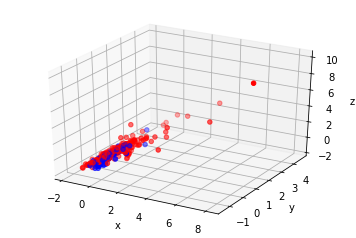

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Subsamples
x_sub = x[::1000] # x to have original data (normalized and centered), and x_pc to use the data after the PCA
y_sub = y_train[::1000]

y_color = ['blue' if y_sub[i] > 0. else 'red' for i in range(len(y_sub))]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(x_sub[:, 0], x_sub[:, 1], x_sub[:, 2], c=y_color) # change the numbers to have different plotting axis
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

# Learn a model

## Split the data
Split the data into train and validation set. We first learn the model on the train set, and then test it on the validation set.

The ration gives the percent of the data going to train (ratio = 0.8 means 80% for training and 20% for validating).

In [21]:
seed = 1
ratio = 0.66

# Choose here if you want the original data, or after PCA
x_tr, y_tr, x_te, y_te = split_data(x, y_train, ratio, seed)
print(x_tr.shape, x_te.shape, "\n", x_tr.shape[0] / (x_tr.shape[0]+x_te.shape[0])*100, "% of training")

(165000, 30) (85000, 30) 
 66.0 % of training


## Weight and loss
Compute here the weight and the resulting loss of the chosen model.

In [37]:
## Logistic regression (TODO: doesn't work yet, need to look into it)

# y = {-1; +1} => y = {0; +1}
y_log = (y_train + 1) / 2
# Add a "biais" to the input
tx = np.c_[np.ones(N), x_pc]

initial_w = np.zeros(tx.shape[1])
max_iters = 50
gamma     = 0.1

w, loss = logistic_regression(y_log, tx, initial_w, max_iters, gamma)

TypeError: unsupported operand type(s) for *: 'dict' and 'float'

In [22]:
## Least-squares

# Add a "biais" to the input
tx_tr = np.c_[np.ones(x_tr.shape[0]), x_tr]

w, loss_tr = least_squares(y_tr, tx_tr)
print("Train MSE loss =", loss_tr)

# Compute the accuracy
y_tr_pred = predict_labels(w, tx_tr)
accuracy_tr = 1. - np.sum(np.absolute(y_tr - y_tr_pred)) / 2. / y_tr.shape[0]
print("Train Accuracy =", accuracy_tr)

Train MSE loss = 0.340321430058
Train Accuracy = 0.744127272727


## Test the model
Test the learned model on the validation set.

In [23]:
# Add a "biais" to the input
tx_te = np.c_[np.ones(x_te.shape[0]), x_te]

loss_te = compute_mse_loss(y_te, tx_te, w)
print("Test MSE loss =", loss_te)

# Compute the accuracy
y_te_pred = predict_labels(w, tx_te)
accuracy_te = 1. - np.sum(np.absolute(y_te - y_te_pred)) / 2. / y_te.shape[0]
print("Test Accuracy =", accuracy_te)

Test MSE loss = 0.340643402784
Test Accuracy = 0.743588235294


# Predict the Kaggle labels
Try to predicts the labels of the test set, then create a submission to be posted on Kaggle.

## Send the test set into the same space as the train set
In order to use the same weight, we need to send the testing data into the same space as the during the training (i.e. normalization, centering, PCA, etc.).

In [24]:
# Create a boolean mask with False at missing values
x_test_mask = (x_test != -999.0)

# Normalize and center the data
x_kaggle = (x_test - x_train_mean) / x_train_std
# Set to 0 (the mean) the missing values
x_kaggle[np.invert(x_test_mask)] = 0.

# Send the data to PCA space
x_kaggle_pc = x_kaggle.dot(eigenvectors)

# Add a "bias" to the input (choose if you want the original, or PCAed data here)
tx_kaggle = np.c_[np.ones(x_kaggle.shape[0]), x_kaggle]

## Predict the labels, and create a submission

In [25]:
# Predict the labels
y_pred = predict_labels(w, tx_kaggle)

# Create a sumbission file to be uploaded to the Kaggle competition
create_csv_submission(ids_test, y_pred, "nico_LS_subm.csv")